In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy


![alt text](map.jpg "Схема GPS")

# Агрохимия 

In [2]:
agrochemistry_total = pd.read_csv('полевые данные общая/ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns

Index(['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Общий углерод, %',
       'М.д. содержания  гипса (по Хитрову), %',
       'Массовая доля иона хлорида, ммоль/100 г',
       'Массовая доля иона сульфата, ммоль/100 г',
       'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
       'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы',
       'Сумма поглощенных оснований по Каппену, ммоль/100 г',
       'Массовая доля плотного остатка водной вытяжки, %',
       'Карбонат и бикарбонат-ионы, ммоль/100 г',
       'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
       'Массовая доля общего содержания карб

In [3]:
agrochemistry_total["GPS №"].unique()
pp_points = ["525","526","527","528","586"]

### Агрохимические показатели по пахатному горизонту

In [4]:
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']
agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]


In [5]:

def aov_for_nominal(df, agrochem_property):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    agrochem_property
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '')
    reg = ols('Органическийуглерод ~ Год + Глубина  +  Типобработки + GPS ' ,  data=dispers).fit()
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

def anova(df, varible, agrochem_property):
    stat_test_df = pd.DataFrame()
    for ind,depth in enumerate(df["Глубина"].unique()): 
        df_by_depth = df[df["Глубина"] == depth]
        sample_list = []
        for value  in df[varible].unique():
            sample = df_by_depth[agrochem_property][df[varible] == value].values
            sample_list.append(sample) 
        
        p_val = ANOVA(*sample_list)[1]
        local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
        stat_test_df = stat_test_df.append(local_df)
    stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
    return(stat_test_df)
    
def ploting( df, hue,  agrochem_property , aov ,stat_test_df, to_lable = "по обработкам" ):
    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
    ax2 = plt.subplot2grid((3,2), (2, 0))
    ax3 = plt.subplot2grid((3,2), (2, 1))

    sns.pointplot(data = df,
        x = "Глубина",
        y = agrochem_property,
        hue = hue,
        pallet = 'Set1',
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
        ax = ax1)
    ax1.set_title('Сравнение по {}'.format(to_lable))

    ax2.axis('off')
    ax2.axis('tight')
    ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
    ax2.set_title('Дисперсионный анализ \nпо {} (MANOVA)'.format(to_lable),  y=0.75 , x = 0.5)

    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
    ax3.set_title('Сравнение выборок \nпо {} (ANOVA)'.format(to_lable),  y=0.75 , x = 0.5)
    plt.show(block=True)
    return fig 

def data_processing(df, type_ , agrochem_property , to_lable = "1" ):
    stats_type = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
    features = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность']
    features.append(agrochem_property) #добавление фичи
    df = agrochemistry_main[features]
    stats = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})

    aov = aov_for_nominal(df)
    stat_test_df = anova(df, type_, agrochem_property)
    fig = ploting(df, type_, agrochem_property, aov,stat_test_df,to_lable  )

    return(stats , aov, stat_test_df,fig )


#### отобрали данные

In [15]:
a = 'Общий азот, %'
a.replace(r'[ ]', '')

'Общий азот, %'

описательные статистики

In [239]:
stats_type = df.groupby(['Тип обработки','Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
stats_gps = df[df['GPS №'].isin(pp_points)].groupby(['GPS №','Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
#"среднее" 'стнд.откл'"коэф вариации"
stats_gps.reset_index()

GPS № Глубина Органический углерод, %                    
                                     std      mean variation
0    525    0-10                0.156500  1.127491  0.124150
1    525   10-20                0.106397  1.050340  0.090603
2    525   20-30                0.185088  1.150560  0.143884
3    526    0-10                0.628614  0.942920  0.596285
4    526   10-20                0.530678  1.076960  0.440734
5    526   20-30                0.112353  1.054080  0.095336
6    527    0-10                0.905368  1.578800  0.512912
7    527   10-20                0.162072  1.263960  0.114688
8    527   20-30                0.095892  1.239960  0.069170
9    528    0-10                0.100986  1.213600  0.074427
10   528   10-20                0.150471  1.066940  0.126142
11   528   20-30                0.082270  1.167594  0.063022
12   586    0-10                0.242671  1.489880  0.145684
13   586   10-20                0.068942  1.003760  0.061433
14   586   20-30                0.349098  1.112120  0.280764

дисперсионный анализ по по номинативным переменным

In [240]:
dispers = df.copy()
dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '')
reg = ols('Органическийуглерод ~ Год + Глубина  +  Типобработки + GPS ' ,  data=dispers).fit()
aov = sm.stats.anova_lm(reg)
aov = aov[["PR(>F)"]]
aov.columns = ['p-value']
aov = aov.iloc[:4,:]
aov['p-value'] = round(aov['p-value'] , 4)





T тест по выборкам

In [241]:
stat_test_df = pd.DataFrame()
for ind,depth in enumerate(df["Глубина"].unique()) :
    df_00_10 = df[df["Глубина"] == depth]
    a = df_00_10["Органический углерод, %"][df['Тип обработки'] == 'ПП'].values
    b = df_00_10["Органический углерод, %"][df['Тип обработки'] == 'ТТ'].values
    p_val = ANOVA(a,b)[1]
    local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
    stat_test_df = stat_test_df.append(local_df)
stat_test_df["p-value"] = round(stat_test_df["p-value"],3)


Text(0.5, 0.75, 'Сравнение выборок \nпо обработкам (ANOVA)')

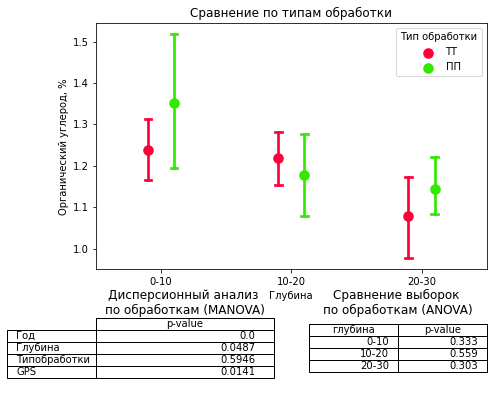

In [242]:
fig = plt.figure(figsize=(7,7))
ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
ax2 = plt.subplot2grid((3,2), (2, 0))
ax3 = plt.subplot2grid((3,2), (2, 1))

sns.pointplot(data = df,
    x = "Глубина",
    y = "Органический углерод, %",
    hue = "Тип обработки",
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.2,
    join = False,
    capsize = .05,
    ax = ax1)
ax1.set_title('Сравнение по типам обработки')

ax2.axis('off')
ax2.axis('tight')
ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
ax2.set_title('Дисперсионный анализ \nпо обработкам (MANOVA)',  y=0.75 , x = 0.5)

ax3.axis('off')
ax3.axis('tight')
ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
ax3.set_title('Сравнение выборок \nпо обработкам (ANOVA)',  y=0.75 , x = 0.5)




Собираем все в одно

In [279]:

def aov_for_nominal(df):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '')
    reg = ols('Органическийуглерод ~ Год + Глубина  +  Типобработки + GPS ' ,  data=dispers).fit() # вот тут надо перекрутить этот момент не ясный как сделать аргумент без служебных символов 
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

def anova(df, varible):
    stat_test_df = pd.DataFrame()
    for ind,depth in enumerate(df["Глубина"].unique()): 
        df_by_depth = df[df["Глубина"] == depth]
        sample_list = []
        for value  in df[varible].unique():
            sample = df_by_depth["Органический углерод, %"][df[varible] == value].values
            sample_list.append(sample) 
        
        p_val = ANOVA(*sample_list)[1]
        local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
        stat_test_df = stat_test_df.append(local_df)
    stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
    return(stat_test_df)
    
def ploting( df, hue,  agrochem_property , aov ,stat_test_df, to_lable = "по обработкам" ):
    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
    ax2 = plt.subplot2grid((3,2), (2, 0))
    ax3 = plt.subplot2grid((3,2), (2, 1))

    sns.pointplot(data = df,
        x = "Глубина",
        y = agrochem_property,
        hue = hue,
        pallet = 'Set1',
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
        ax = ax1)
    ax1.set_title('Сравнение по {}'.format(to_lable))

    ax2.axis('off')
    ax2.axis('tight')
    ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
    ax2.set_title('Дисперсионный анализ \nпо {} (MANOVA)'.format(to_lable),  y=0.75 , x = 0.5)

    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
    ax3.set_title('Сравнение выборок \nпо {} (ANOVA)'.format(to_lable),  y=0.75 , x = 0.5)
    plt.show(block=True)
    return fig 

def data_processing(df, type_ , agrochem_property , to_lable = "1" ):
    stats_type = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
    features = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность']
    features.append(agrochem_property) #добавление фичи
    df = agrochemistry_main[features]
    stats = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})

    aov = aov_for_nominal(df)
    stat_test_df = anova(df, type_)
    fig = ploting(df, type_, agrochem_property, aov,stat_test_df,to_lable  )

    return(stats , aov, stat_test_df,fig )


    

понять почему все падает на моменте когда у нас данные по точкам

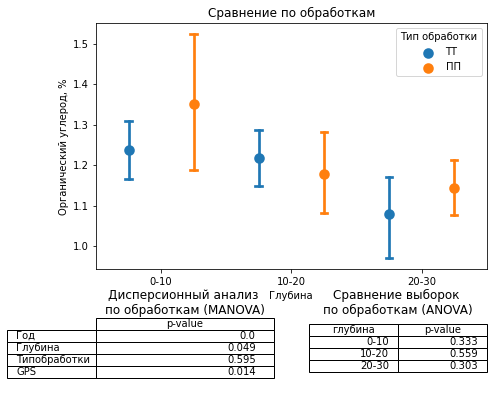

(                      Органический углерод, %                    
                                           std      mean variation
 Тип обработки Глубина                                            
 ПП            0-10                   0.506985  1.350852  0.369577
               10-20                  0.284810  1.178302  0.238022
               20-30                  0.186345  1.144863  0.159478
 ТТ            0-10                   0.170553  1.238589  0.134381
               10-20                  0.165052  1.218601  0.132179
               20-30                  0.207144  1.078673  0.185524,
               p-value
 Год             0.000
 Глубина         0.049
 Типобработки    0.595
 GPS             0.014,
   глубина  p-value
 0    0-10    0.333
 1   10-20    0.559
 2   20-30    0.303,
 <Figure size 504x504 with 3 Axes>)

In [280]:
data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = "Органический углерод, %", to_lable = "обработкам")

In [281]:
by_points = agrochemistry_main[agrochemistry_main["GPS №"].isin(pp_points)]

In [17]:
a = "Органический углерод, %"
a = a.replace(r'[\(),.%№ /-]', '')
a

'Органический углерод, %'

C:\Users\User\Anaconda3\envs\gee\lib\site-packages\scipy\stats\stats.py:3680: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


ValueError: Invalid RGBA argument: 0.21538975947324868

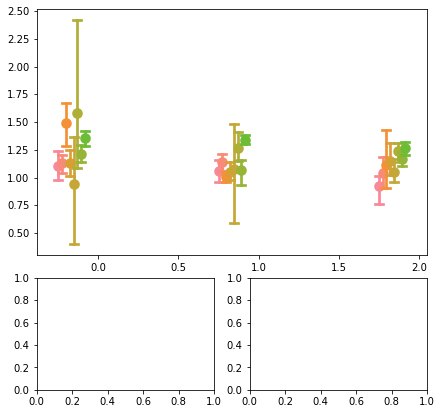

In [283]:
data_processing(df = by_points, type_ = "GPS №", agrochem_property = "Органический углерод, %", to_lable = "обработкам")

In [271]:
by_points

,Год,GPS №,Тип обработки,Глубина,повторность,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Органический углерод, %"
48,2021,586,ПП,0-10,[0],7.18,7.83,28.200000,688.801176,0.20,1.4504
49,2021,586,ПП,10-20,[0],7.16,8.34,14.600000,598.958696,0.13,0.9396
50,2021,586,ПП,20-30,[0],7.20,8.19,19.800000,600.909176,0.14,1.0024
60,2021,586,ПП,0-10,[1],7.25,7.99,19.200000,560.960456,0.15,1.1110
61,2021,586,ПП,10-20,[1],7.12,7.91,16.400000,573.554296,0.15,1.0865
...,...,...,...,...,...,...,...,...,...,...,...
195,2020,528,ПП,10-20,[3],7.21,8.34,11.740558,327.199040,0.16,1.0693
196,2020,528,ПП,20-30,[3],7.27,8.61,10.755337,277.907280,0.16,1.2020
197,2020,528,ПП,0-10,[4],7.20,8.12,12.233169,454.774880,0.16,1.1344
198,2020,528,ПП,10-20,[4],7.19,8.23,13.218391,440.928880,0.17,1.1627


In [230]:
df = agrochemistry_main[agrochemistry_main['GPS №'].isin(pp_points)]
varible = 'GPS №'
anova(df, varible)

,глубина,p-value
0,0-10,0.300
1,10-20,0.588
2,20-30,0.640


In [226]:
df
varible = 'Тип обработки'
anova(df, varible)

,глубина,p-value
0,0-10,0.333
1,10-20,0.559
2,20-30,0.303


In [219]:
for ind,depth in enumerate(df["Глубина"].unique()) : #вот это надо перекрутить! потому что когда у нас будет выборка по ключевым участкам все упадет
    df_00_10 = df[df["Глубина"] == depth]
    a = df_00_10["Органический углерод, %"][df['Тип обработки'] == 'ПП'].values
    b = df_00_10["Органический углерод, %"][df['Тип обработки'] == 'ТТ'].values
    p_val = ANOVA(a,b)[1]
    local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
    stat_test_df = stat_test_df.append(local_df)
stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
stat_test_df

,глубина,p-value
0,0-10,0.333
1,10-20,0.559
2,20-30,0.303
0,0-10,0.333
1,10-20,0.559
2,20-30,0.303
0,0-10,0.333
1,10-20,0.559
2,20-30,0.303


In [ ]:

sns.pointplot(data = agrochemistry_main,
    x = "Глубина",
    y = "Органический углерод, %",
    hue = "Тип обработки",
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.2,
    join = False,
    capsize = .05,
    ax = ax1)

In [ ]:
reg = ols('Органическийуглерод ~ Глубина +  Типобработки + GPS ' ,  data=dispers[dispers['GPS'].isin(pp_points)]).fit()
aov = sm.stats.anova_lm(reg)
aov = aov[["PR(>F)"]]
aov.columns = ['p-value']
aov = aov.iloc[:4,:]


aov['p-value'] = round(aov['p-value'] , 3)

fig, ax = plt.subplots(figsize=(1,1.5))
ax.axis('off')
ax.axis('tight')
ax.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')

Text(0.5, 1.0, 'Сравнение по ключевым участкам')

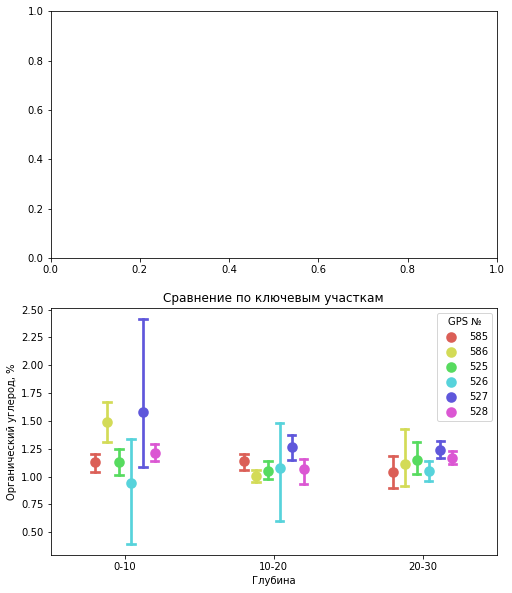

In [127]:
f, ax = plt.subplots(2,1,figsize=(8,10))

sns.pointplot(
    data = agrochemistry_main[agrochemistry_main['GPS №'].isin(pp_points)],
    x = "Глубина",
    y = "Органический углерод, %",
    hue = 'GPS №',
    palette = "hls",
    scale = 1.2,
    ci = 95,
    dodge= 0.4,
    join = False,
    capsize = .05,
    ax = ax[1])
ax[1].set_title('Сравнение по ключевым участкам')

<AxesSubplot:xlabel='Глубина', ylabel='Органический углерод, %'>

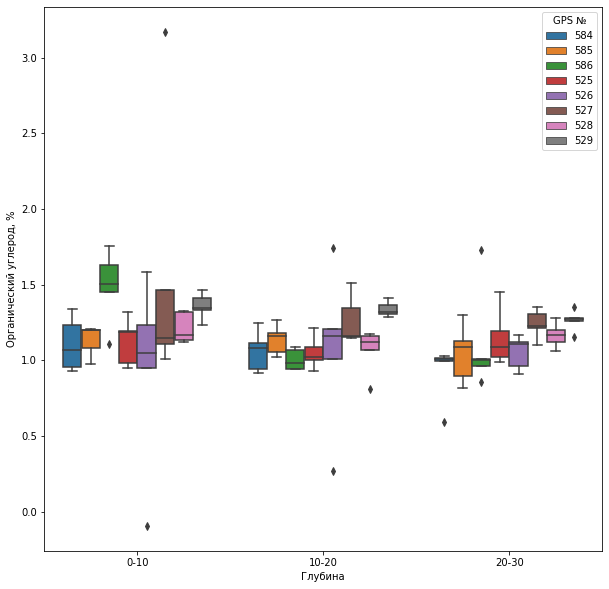

In [114]:
f, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data = agrochemistry_main[agrochemistry_main['Год'].isin(['2020','2021'])], x = "Глубина", y = "Органический углерод, %", hue = "GPS №", ax = ax)


In [127]:
agrochemistry_main.columns = agrochemistry_main.columns.str.replace(r'[\(),.%№ /-]', '')
reg = ols('Органическийуглерод ~GPS + Год + Типобработки + Глубина' ,  data=agrochemistry_main[agrochemistry_main['Год'] != '2019' ]).fit()
aov = sm.stats.anova_lm(reg)



aov

<ipython-input-127-a61e52bcc3ec>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  agrochemistry_main.columns = agrochemistry_main.columns.str.replace(r'[\(),.%№ /-]', '')


,df,sum_sq,mean_sq,F,PR(>F)
GPS,7.0,1.621135,0.231591,2.870035,0.008628
Год,1.0,0.005110,0.005110,0.063329,0.801779
Типобработки,1.0,0.052482,0.052482,0.650391,0.421713
Глубина,2.0,0.423514,0.211757,2.624243,0.077030
Residual,110.0,8.876194,0.080693,NaN,NaN


In [120]:
agrochemistry_main.columns

Index(['Год', 'GPS', 'Типобработки', 'Глубина', 'повторность',
       'рНсолевойвытяжкиедрН', 'рНводнойвытяжкиедрН',
       'Фосфорподвижнаяформамгкг', 'Калийподвижнаяформамлн1', 'Общийазот',
       'Общийуглерод', 'Органическийуглерод'],
      dtype='object')

LinAlgError: Singular matrix